# Football pass probability model
> A notebook exploring a dataset of football match 'event' data to build a model which predicts the probability of a pass reaching a teammate.

- toc: true 
- badges: false
- comments: true
- categories: [classification]
- image: images/invincibles.png
- author: Aidan Hood

## Introduction
The aim of this project was to build a proof of concept model to predict the probability of a football pass reaching a teammate succesfully, based on a dataset of football match event data. The dataset used is the Metrica Sports Sample Data, which an be found at : https://github.com/metrica-sports/sample-data. The Metrica Sports repository also included player tracking data that aligns to the event data sets, which has not been used in this model, but I outline how I think this could be used to build on this model at the end of this notebook.

In short, I approached this problem as a binary classification problem, where a pass can be classified as succesful, or not. The probability of the pass being succesful can then be simply dervied as the proabbility of a data point belonging to either class, which is easy to derive from almost all classificiation models. This greatly simplifies the ask, and allowed me to use familair classification modelling techniques as opposed to more complex statistical probability models.

I broadly split the problem into the following stages:
1. Data input and cleaning
2. Data exploration
3. Feature selection and engineering
4. Model selection and training
5. Model evalaution
6. Thought on how this model could be built upon

All in all, I created a model with a balanced accuracy score of ~70% and an ROC AUC score of ~0.75. This was pretty good, although far from perfect, and could definitley be improved on if I worked on this project full time.

This notebook includes the full code for the project, but I have made the code snippets collapsable in case you are just interested in the explanations and outputs.

Thanks for reading!



## Libraries

The imported libraries are fairly standard, including various sklearn packages, pandas and matplotlib. The only rogue library I utilised was the imbalanced-learn library (https://github.com/scikit-learn-contrib/imbalanced-learn), which helped with dealing with class imbalance. I also filtered out warnings as they were getting annoying without actually telling me much.

In [1]:
#collapse-hide
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings(action='ignore')

pd.set_option("max_columns", 50)

## Data cleaning
The first step was to read in the dataset and quickly take a look at the dataframe.

In [2]:
#collapse-hide
df = pd.read_csv("./Sample_Game_1/Sample_Game_1_RawEventsData.csv")
df

,Team,Type,Subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
0,Away,SET PIECE,KICK OFF,1,1,0.04,0,0.00,Player19,NaN,NaN,NaN,NaN,NaN
1,Away,PASS,NaN,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,Away,PASS,NaN,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,Away,PASS,NaN,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,Away,PASS,NaN,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1740,Home,PASS,NaN,2,143361,5734.44,143483,5739.32,Player12,Player13,0.60,0.33,0.19,0.95
1741,Home,PASS,NaN,2,143578,5743.12,143593,5743.72,Player13,Player4,0.09,0.88,0.14,0.69
1742,Home,BALL LOST,INTERCEPTION,2,143598,5743.92,143618,5744.72,Player4,NaN,0.13,0.69,0.07,0.61
1743,Away,RECOVERY,BLOCKED,2,143617,5744.68,143617,5744.68,Player16,NaN,0.05,0.62,NaN,NaN


Next, I thought it would be useful to look at what unique values were under the 'Type' column and the 'Subtype' column - i.e. what different types of events were in the dataset. This through up a significant amount of subtypes.

In [9]:
#collapse-hide
print('Types: ',df.Type.unique(),'\n')
print('Subtypes: ',df.Subtype.unique())

Types:  ['SET PIECE' 'PASS' 'BALL LOST' 'RECOVERY' 'CHALLENGE' 'BALL OUT' 'SHOT'
 'FAULT RECEIVED' 'CARD'] 

Subtypes:  ['KICK OFF' nan 'INTERCEPTION' 'HEAD-INTERCEPTION' 'AERIAL-LOST'
 'AERIAL-WON' 'HEAD' 'CORNER KICK' 'CROSS' 'HEAD-ON TARGET-GOAL'
 'THROW IN' 'GROUND-LOST' 'GROUND-WON' 'TACKLE-WON' 'THEFT' 'TACKLE-LOST'
 'OFF TARGET-OUT' 'GOAL KICK' 'CROSS-INTERCEPTION'
 'GOAL KICK-INTERCEPTION' 'DEEP BALL' 'ON TARGET-SAVED' 'SAVED'
 'HEAD-FORCED' 'AERIAL-FAULT-LOST' 'AERIAL-FAULT-WON' 'FREE KICK'
 'HEAD-CLEARANCE' 'CLEARANCE' 'GROUND-FAULT-WON' 'GROUND-FAULT-LOST'
 'HEAD-OFF TARGET-OUT' 'DRIBBLE-WON' 'OFFSIDE' 'TACKLE-FAULT-LOST'
 'TACKLE-FAULT-WON' 'GROUND' 'FORCED' 'YELLOW' 'THROUGH BALL-DEEP BALL'
 'HEAD-ON TARGET-SAVED' 'BLOCKED' 'TACKLE-ADVANTAGE-LOST'
 'TACKLE-ADVANTAGE-WON' 'GROUND-ADVANTAGE-LOST' 'END HALF'
 'HEAD-WOODWORK-OUT' 'WOODWORK-GOAL' 'ON TARGET-GOAL' 'WOODWORK'
 'REFEREE HIT' 'OFF TARGET']


To narrow the dataset down to just the passes and attempted passes, I created two new dataframes; one for all datapoints under the 'pass' type, and one for all datapoints under the 'ball lost' type.

I then took a look at the subtypes of both the 'pass' dataframe and the 'ball lost' dataframe, which still included many subtypes that were not relevant, specifically in the 'ball lost' dataframe.

In [10]:
#collapse-hide
df_pass = df[df['Type'] =='PASS']
df_lost = df[df['Type'] =='BALL LOST']

print('Pass Subtypes: ',df_pass.Subtype.unique(),'\n')
print('Ball Lost Subtypes: ',df_lost.Subtype.unique())

Pass Subtypes:  [nan 'HEAD' 'CROSS' 'GOAL KICK' 'DEEP BALL' 'THROUGH BALL-DEEP BALL'
 'HEAD-CLEARANCE' 'CLEARANCE'] 

Ball Lost Subtypes:  ['INTERCEPTION' 'HEAD-INTERCEPTION' nan 'THEFT' 'HEAD'
 'CROSS-INTERCEPTION' 'GOAL KICK-INTERCEPTION' 'HEAD-FORCED' 'OFFSIDE'
 'FORCED' 'CLEARANCE' 'END HALF' 'GOAL KICK' 'HEAD-CLEARANCE' 'DEEP BALL'
 'WOODWORK' 'REFEREE HIT']


The 'ball lost' data still needed trimming to remove all the irrelevant subtypes. To do this I wrote some code which only kept the various 'interception' subtypes, as well as the two 'clearance' subtypes, the 'goal kick' subtype and the 'deep ball' subtype.

In [11]:
#collapse-hide
condition = (df_lost.Subtype != '') & (df_lost.Subtype != ' ') & (df_lost.Subtype != 'THEFT') &  (df_lost.Subtype != 'HEAD') & (df_lost.Subtype != 'HEAD-FORCED') & (df_lost.Subtype != 'OFFSIDE') &  (df_lost.Subtype != 'FORCED') & (df_lost.Subtype != 'END HALF') & (df_lost.Subtype != 'WOODWORK') & (df_lost.Subtype != 'REFEREE HIT')

df_lost_trimmed = df_lost[condition]
df_lost_trimmed = df_lost_trimmed.dropna(subset=['Subtype'])

So, now I have what I beleive to be all the types of events which consitute either a succesfull pass, or a failed pass. I have made the assumption that set pieces do not count as passes, offsides are discounted and clearances do count as passes.

In [13]:
#collapse-hide
print('Pass Subtypes: ',df_pass.Subtype.unique(),'\n')
print('Ball Lost Subtypes: ',df_lost_trimmed.Subtype.unique())

Pass Subtypes:  [nan 'HEAD' 'CROSS' 'GOAL KICK' 'DEEP BALL' 'THROUGH BALL-DEEP BALL'
 'HEAD-CLEARANCE' 'CLEARANCE'] 

Ball Lost Subtypes:  ['INTERCEPTION' 'HEAD-INTERCEPTION' 'CROSS-INTERCEPTION'
 'GOAL KICK-INTERCEPTION' 'CLEARANCE' 'GOAL KICK' 'HEAD-CLEARANCE'
 'DEEP BALL']


With the data trimmed down to just pass related data, I put the two dataframes back together into a master 'pass' dataframe and did some additionaly cleaning. This included:
- Renaming the type column to 'pass_sucess', where any 'pass' type was converted to 1 and any 'ball lost' type to 0. This now is the dependent variable.
- Fill any NaN values appropriatley. For 'subtype' NaN values, I relablled these as 'standard' to represent passes/attempted passes without a subtype.
- Stanardised the subtypes so that they are independent of if the pass was succesful or not. For example, I ensured that datpoints labelled as 'cross-interception' and 'cross' were both just labelled as 'cross' subtypes. This, combined with the above bulet point, allowed me to simplify the data even further to the point of having 6 substypes of pass/attempted pass: 'STANDARD', 'HEAD', 'CROSS', 'GOAL KICK', 'DEEP BALL', 'CLEARANCE'.
- Changining the 'Team' column to a binary feature of 'home_team' where 1 represents the home team and 0 the away team.
- Changining the 'Period' column values from 1 and 2, to 0 and 1 respectivley, and renaming the column to 'first_half' 

After all this, the dataframe is clean, and is just representing succesful and failed passes! See below for what it now looks like.

In [14]:
#collapse-hide
pass_data = pd.concat([df_pass, df_lost_trimmed])

pass_data.rename(columns={'Type': 'pass_sucess'}, inplace=True)
pass_data["pass_sucess"].replace({"PASS": 1, "BALL LOST": 0}, inplace=True)

pass_data.dropna(subset = ["End X"], inplace=True)

pass_data["Subtype"].fillna("STANDARD", inplace=True)

pass_data["Subtype"].replace({"INTERCEPTION": "STANDARD"}, inplace=True)
pass_data["Subtype"].replace({"HEAD-INTERCEPTION": "HEAD"}, inplace=True)
pass_data["Subtype"].replace({"THROUGH BALL-DEEP BALL": "DEEP BALL"}, inplace=True)
pass_data["Subtype"].replace({"CROSS-INTERCEPTION": "CROSS"}, inplace=True)
pass_data["Subtype"].replace({"HEAD-CLEARANCE": "CLEARANCE"}, inplace=True)
pass_data["Subtype"].replace({"GOAL KICK-INTERCEPTION": "GOAL KICK"}, inplace=True)

pass_data["Team"].replace({"Away": 0}, inplace=True)
pass_data["Team"].replace({"Home": 1}, inplace=True)
pass_data.rename(columns={'Team': 'home_team'}, inplace=True)

pass_data["Period"].replace({2: 0}, inplace=True)
pass_data.rename(columns={'Period': 'first_half'}, inplace=True)

pass_data

,home_team,pass_sucess,Subtype,first_half,Start Frame,Start Time [s],End Frame,End Time [s],From,To,Start X,Start Y,End X,End Y
1,0,1,STANDARD,1,1,0.04,3,0.12,Player19,Player21,0.45,0.39,0.55,0.43
2,0,1,STANDARD,1,3,0.12,17,0.68,Player21,Player15,0.55,0.43,0.58,0.21
3,0,1,STANDARD,1,45,1.80,61,2.44,Player15,Player19,0.55,0.19,0.45,0.31
4,0,1,STANDARD,1,77,3.08,96,3.84,Player19,Player21,0.45,0.32,0.49,0.47
5,0,1,STANDARD,1,191,7.64,217,8.68,Player21,Player22,0.40,0.73,0.32,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,1,0,STANDARD,0,140619,5624.76,140681,5627.24,Player7,NaN,0.72,0.11,0.42,0.17
1732,0,0,STANDARD,0,142886,5715.44,142938,5717.52,Player27,NaN,0.72,0.08,0.85,0.32
1734,1,0,CLEARANCE,0,142943,5717.72,143008,5720.32,Player2,NaN,0.85,0.32,0.48,0.34
1737,0,0,STANDARD,0,143229,5729.16,143247,5729.88,Player18,NaN,0.68,0.30,0.77,0.23


## Data exploration
Firstly, I wanted to get a feel for the distribution of all of the features. The important things to note from this visualisation are:
- The classes are substantiously imbalcned, with many more passes being succesful than failed. This caused issues with the model, and are addressed later in the project.
- The 'start time' and 'end time' features, are carbon copies of the 'start frame' and 'end frame' features, albeit with different scales. As such, one set of these can be removed, which is handled later on.
- It is interesting that 'standard' passes are by far the most common.
- There are several features which are categorcial. This is handled later on.

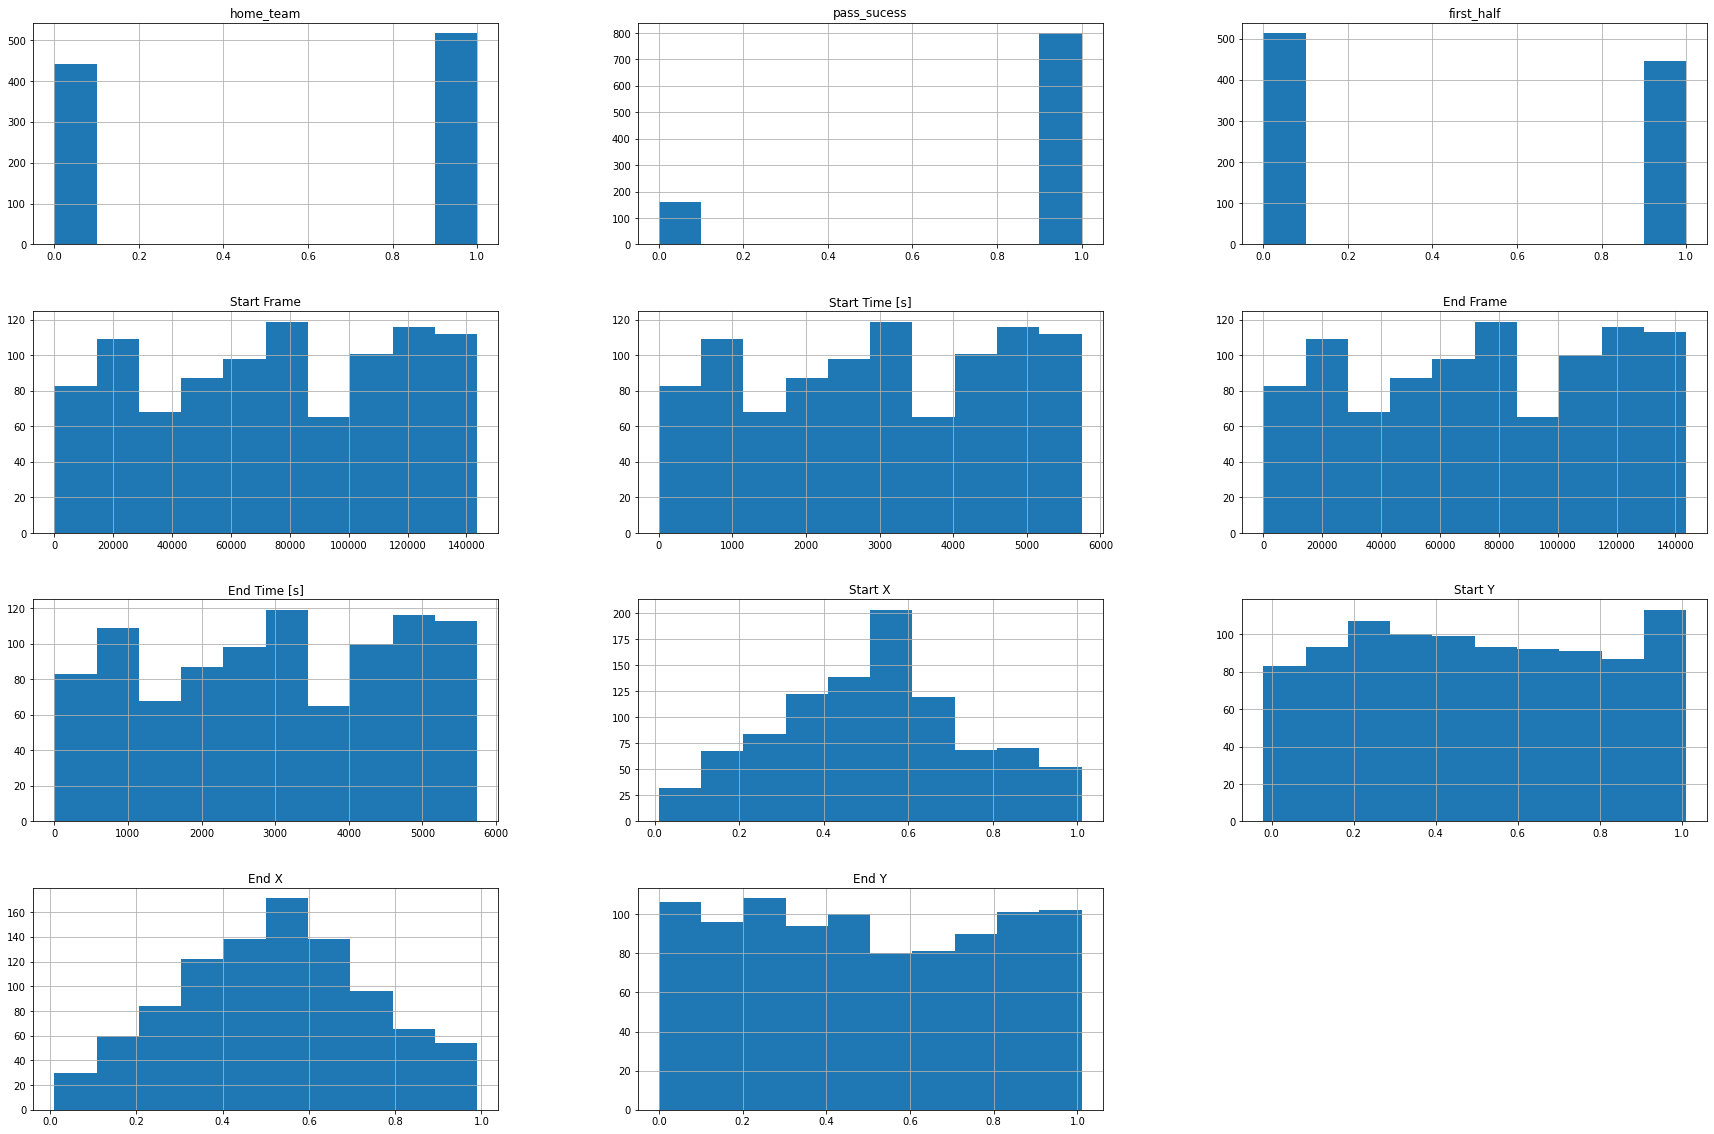

In [15]:
#collapse-hide
pass_data.hist(figsize=(30,20))
plt.show()

<AxesSubplot:>

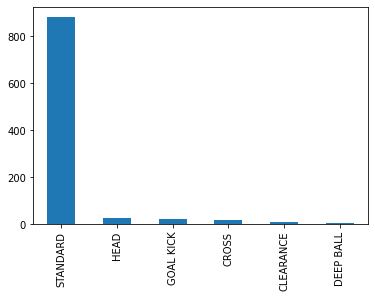

In [16]:
#collapse-hide
pass_data['Subtype'].value_counts().plot(kind='bar')

<AxesSubplot:>

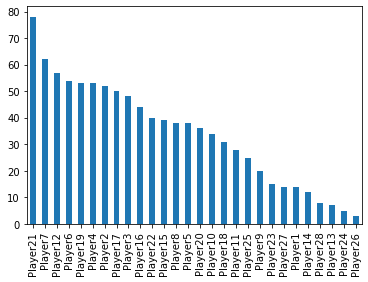

In [17]:
#collapse-hide
pass_data['From'].value_counts().plot(kind='bar')

<AxesSubplot:>

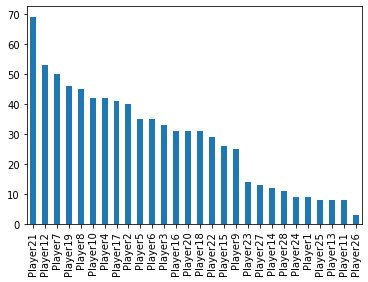

In [18]:
#collapse-hide
pass_data['To'].value_counts().plot(kind='bar')

## Feature selection and engineering
Firstly, I dealt with the duplicated data by taking out the 'start frame' and 'end frame' features, as their information was captured by the time columns. 

I also removed the 'To' column. This was a feature that I had to really think about omitting. On one hand, it holds some valuabkle infiormation, as there could be a relationship between pass success and which player was being passed to. However, the dataset did not include 'To' data for passes that were incomplete/failed/intercepetd. As such, I would not have this data for the failed pass class, and this would cause major bias in the model as the model would essentially know if a pass was succesful just from seeing that the 'To' column had a value. As a result, i decided to just omit the feature for integirty and ,to some degree, simplicity.

I also questioned the utility of the 'end time' feature. Any information about the game, such as how long the game had been played for, would be captured in the start time feature. The only additonal information that the end time feature carries is how long the pass took to reach a teammate or be intercepted. As such, I created a new column called 'pass_length' which was equal to the 'end time' minus the 'start time', and removed the 'end time' column from the data.

After all this feature selection, the dataframe was close to being in its final state.

In [19]:
pass_data.drop(['Start Frame', 'End Frame', 'To'], axis=1, inplace=True)

new_column = pass_data["End Time [s]"] - pass_data["Start Time [s]"]
pass_data["pass_length"] = new_column

pass_data.drop(['End Time [s]'], axis=1, inplace=True)

pass_data

,home_team,pass_sucess,Subtype,first_half,Start Time [s],From,Start X,Start Y,End X,End Y,pass_length
1,0,1,STANDARD,1,0.04,Player19,0.45,0.39,0.55,0.43,0.08
2,0,1,STANDARD,1,0.12,Player21,0.55,0.43,0.58,0.21,0.56
3,0,1,STANDARD,1,1.80,Player15,0.55,0.19,0.45,0.31,0.64
4,0,1,STANDARD,1,3.08,Player19,0.45,0.32,0.49,0.47,0.76
5,0,1,STANDARD,1,7.64,Player21,0.40,0.73,0.32,0.98,1.04
...,...,...,...,...,...,...,...,...,...,...,...
1712,1,0,STANDARD,0,5624.76,Player7,0.72,0.11,0.42,0.17,2.48
1732,0,0,STANDARD,0,5715.44,Player27,0.72,0.08,0.85,0.32,2.08
1734,1,0,CLEARANCE,0,5717.72,Player2,0.85,0.32,0.48,0.34,2.60
1737,0,0,STANDARD,0,5729.16,Player18,0.68,0.30,0.77,0.23,0.72


I then split the dataframe into two; one for the dependent variable 'y' (the class varibale; succesfull pass or failed pass), and a feature dataframe 'x'.

In [705]:
x = pass_data.drop(['pass_sucess'], axis=1)
y = pass_data['pass_sucess']

In [706]:
cat_features_string = ['Subtype','From']
cat_features = [x.Subtype, x.From]

for i in range(len(cat_features_string)):
    x_temp = pd.get_dummies(cat_features[i], prefix=cat_features_string[i])
    x = x.drop(cat_features_string[i],axis=1)
    x = x.join(x_temp)

In [707]:
x

,home_team,first_half,Start Time [s],Start X,Start Y,End X,End Y,pass_length,Subtype_CLEARANCE,Subtype_CROSS,Subtype_DEEP BALL,Subtype_GOAL KICK,Subtype_HEAD,Subtype_STANDARD,From_Player1,From_Player10,From_Player11,From_Player12,From_Player13,From_Player14,From_Player15,From_Player16,From_Player17,From_Player18,From_Player19,From_Player2,From_Player20,From_Player21,From_Player22,From_Player23,From_Player24,From_Player25,From_Player26,From_Player27,From_Player28,From_Player3,From_Player4,From_Player5,From_Player6,From_Player7,From_Player8,From_Player9
1,0,1,0.04,0.45,0.39,0.55,0.43,0.08,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0.12,0.55,0.43,0.58,0.21,0.56,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,1.80,0.55,0.19,0.45,0.31,0.64,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,3.08,0.45,0.32,0.49,0.47,0.76,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,7.64,0.40,0.73,0.32,0.98,1.04,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1712,1,0,5624.76,0.72,0.11,0.42,0.17,2.48,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1732,0,0,5715.44,0.72,0.08,0.85,0.32,2.08,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1734,1,0,5717.72,0.85,0.32,0.48,0.34,2.60,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1737,0,0,5729.16,0.68,0.30,0.77,0.23,0.72,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Model selection and training

In [708]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

rus = RandomUnderSampler()
x_train, y_train = rus.fit_resample(x_train, y_train)

x_train, y_train = SMOTE().fit_resample(x_train, y_train)

In [709]:
#collapse-output
scaler = StandardScaler()
scaler.fit(x_train)
scaler.transform(x_train)
scaler.transform(x_test)

array([[ 0.91986621,  1.13826718, -0.3401298 , ...,  4.39405192,
        -0.21821789, -0.12403473],
       [ 0.91986621, -0.87852836,  1.38545022, ..., -0.22758038,
        -0.21821789, -0.12403473],
       [-1.08711461, -0.87852836,  0.15119883, ..., -0.22758038,
        -0.21821789, -0.12403473],
       ...,
       [ 0.91986621,  1.13826718, -0.38944582, ..., -0.22758038,
         4.58257569, -0.12403473],
       [ 0.91986621, -0.87852836,  0.10625576, ..., -0.22758038,
        -0.21821789, -0.12403473],
       [ 0.91986621, -0.87852836,  1.04577867, ..., -0.22758038,
        -0.21821789, -0.12403473]])

In [710]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   home_team          264 non-null    int64  
 1   first_half         264 non-null    int64  
 2   Start Time [s]     264 non-null    float64
 3   Start X            264 non-null    float64
 4   Start Y            264 non-null    float64
 5   End X              264 non-null    float64
 6   End Y              264 non-null    float64
 7   pass_length        264 non-null    float64
 8   Subtype_CLEARANCE  264 non-null    uint8  
 9   Subtype_CROSS      264 non-null    uint8  
 10  Subtype_DEEP BALL  264 non-null    uint8  
 11  Subtype_GOAL KICK  264 non-null    uint8  
 12  Subtype_HEAD       264 non-null    uint8  
 13  Subtype_STANDARD   264 non-null    uint8  
 14  From_Player1       264 non-null    uint8  
 15  From_Player10      264 non-null    uint8  
 16  From_Player11      264 non

In [711]:
log_regression = linear_model.LogisticRegression()
n_bayes = naive_bayes.GaussianNB()
sgd = linear_model.SGDClassifier()
knn = neighbors.KNeighborsClassifier()
dec_tree = tree.DecisionTreeClassifier()
rand_forest = ensemble.RandomForestClassifier(n_jobs=-1)
svc = svm.SVC()

models = [log_regression, n_bayes, sgd, knn, dec_tree, rand_forest, svc]
model_names = ['Logistic Regression', 'Naive Bayes', 'Stochastic Gradient Descent', 'K-Nearest-Neighbours', 'Decision Tree', 'Random Forest', 'Support Vector Classifier']

In [712]:
print('F1:')
for i in range(len(models)):
    kfold = KFold(n_splits=7)
    result = cross_val_score(models[i], x_train, y_train, cv=kfold, scoring='f1')
    print(model_names[i] + ': ' + str(result.mean()) )

print('Accuracy:')
for i in range(len(models)):
    kfold = KFold(n_splits=7)
    result = cross_val_score(models[i], x_train, y_train, cv=kfold, scoring='accuracy')
    print(model_names[i] + ': ' + str(result.mean()) )

print('Balanced Accuracy:')
for i in range(len(models)):
    kfold = KFold(n_splits=7)
    result = cross_val_score(models[i], x_train, y_train, cv=kfold, scoring='balanced_accuracy')
    print(model_names[i] + ': ' + str(result.mean()) )


F1:
Logistic Regression: 0.3497022085661697
Naive Bayes: 0.4610133715939821
Stochastic Gradient Descent: 0.3842364532019705
K-Nearest-Neighbours: 0.375139146567718
Decision Tree: 0.3775229193139641
Random Forest: 0.3747620688797159
Support Vector Classifier: 0.08637873754152824
Accuracy:
Logistic Regression: 0.4317211948790896
Naive Bayes: 0.6033326559642349
Stochastic Gradient Descent: 0.7894736842105263
K-Nearest-Neighbours: 0.46616541353383456
Decision Tree: 0.5571022149969518
Random Forest: 0.5686852265799635
Support Vector Classifier: 0.07894736842105264
Balanced Accuracy:
Logistic Regression: 0.43197182144550567
Naive Bayes: 0.6026016618121881
Stochastic Gradient Descent: 0.35714285714285715
K-Nearest-Neighbours: 0.4660192147034253
Decision Tree: 0.580381133012712
Random Forest: 0.5569351306193411
Support Vector Classifier: 0.07817460317460319


In [713]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
            }

In [714]:
grid = GridSearchCV(rand_forest, param_grid = parameters, scoring='balanced_accuracy', verbose=1)
grid.fit(x_train, y_train)
print(grid.best_score_)
print(grid.best_params_)  

Fitting 5 folds for each of 6 candidates, totalling 30 fits
0.6743589743589744
{'criterion': 'entropy', 'max_features': 'sqrt'}


In [715]:
rand_forest = ensemble.RandomForestClassifier(criterion = 'gini', max_features='log2', n_jobs=-1)
rand_forest.fit(x_train,y_train)
predictions = rand_forest.predict(x_test)
accuracy = metrics.balanced_accuracy_score(y_test,predictions)
f1 = metrics.f1_score(y_test,predictions)
print('Balanced Accuracy: '+str(accuracy))
print('F1 Score: '+str(f1))


Balanced Accuracy: 0.7158249158249158
F1 Score: 0.7972027972027972


In [716]:
probs = rand_forest.predict_proba(x_test)

print(probs)

[[0.47 0.53]
 [0.38 0.62]
 [0.73 0.27]
 [0.68 0.32]
 [0.73 0.27]
 [0.55 0.45]
 [0.76 0.24]
 [0.39 0.61]
 [0.43 0.57]
 [0.33 0.67]
 [0.46 0.54]
 [0.21 0.79]
 [0.48 0.52]
 [0.37 0.63]
 [0.16 0.84]
 [0.3  0.7 ]
 [0.48 0.52]
 [0.18 0.82]
 [0.78 0.22]
 [0.27 0.73]
 [0.74 0.26]
 [0.88 0.12]
 [0.53 0.47]
 [0.25 0.75]
 [0.4  0.6 ]
 [0.77 0.23]
 [0.44 0.56]
 [0.33 0.67]
 [0.3  0.7 ]
 [0.61 0.39]
 [0.4  0.6 ]
 [0.44 0.56]
 [0.35 0.65]
 [0.65 0.35]
 [0.25 0.75]
 [0.87 0.13]
 [0.34 0.66]
 [0.54 0.46]
 [0.17 0.83]
 [0.88 0.12]
 [0.64 0.36]
 [0.63 0.37]
 [0.43 0.57]
 [0.8  0.2 ]
 [0.2  0.8 ]
 [0.38 0.62]
 [0.4  0.6 ]
 [0.33 0.67]
 [0.61 0.39]
 [0.85 0.15]
 [0.4  0.6 ]
 [0.25 0.75]
 [0.74 0.26]
 [0.5  0.5 ]
 [0.18 0.82]
 [0.49 0.51]
 [0.24 0.76]
 [0.26 0.74]
 [0.56 0.44]
 [0.23 0.77]
 [0.69 0.31]
 [0.57 0.43]
 [0.19 0.81]
 [0.41 0.59]
 [0.61 0.39]
 [0.42 0.58]
 [0.5  0.5 ]
 [0.18 0.82]
 [0.42 0.58]
 [0.34 0.66]
 [0.09 0.91]
 [0.36 0.64]
 [0.73 0.27]
 [0.09 0.91]
 [0.65 0.35]
 [0.48 0.52]
 [0.62 0.38]

# Model evaluation

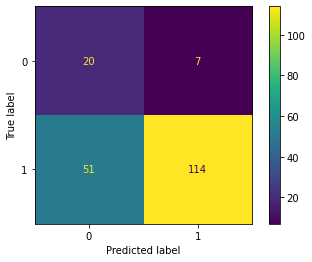

In [717]:
c_matrix = metrics.plot_confusion_matrix(rand_forest, x_test,y_test)
plt.show()

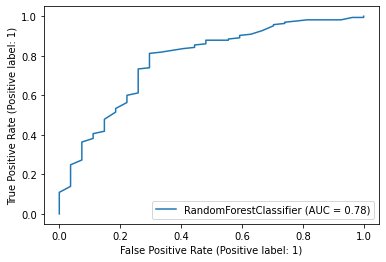

In [718]:
metrics.plot_roc_curve(rand_forest, x_test,y_test)
plt.show()

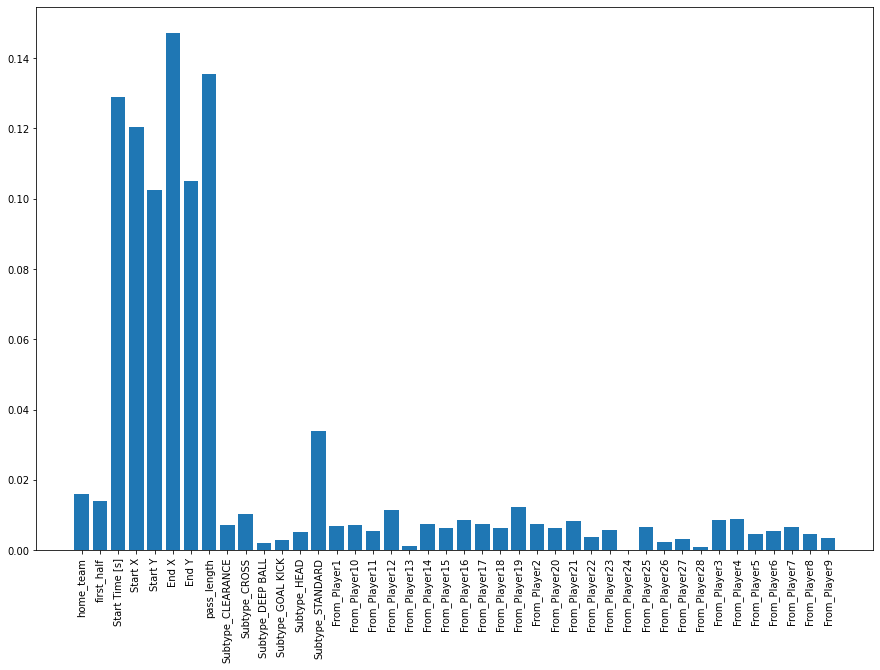

In [719]:
feature_importances = rand_forest.feature_importances_
feature_strings = x_train.columns.tolist()
fig = plt.figure(figsize=[15,10])
plt.xticks(rotation=90)
plt.bar(feature_strings, feature_importances)
plt.show()

# Further work